# **Homework on Credit Risk**
## **Building an Application Scoring Model**

### **General Information**
- **Date assigned:** December 2, 2025  
- **Soft deadline:** 23:59 MSK, December 15, 2025  
- **Hard deadline:** 23:59 MSK, December 18, 2025  
- **Submission:** send your work to  
  \texttt{maria.vorobyova.ser@gmail.com}  
  with the subject format:
  \[
  \text{HSE\_CS\_[track]\_FullName}
  \]
  Example:
  \[
  \text{HSE\_CS\_PAD\_IVANOV\_IVAN\_IVANOVICH}
  \]

---

### **Grading and Penalties**
Maximum score: **10 points**

Late penalty:
\[
\text{Final Score} = 10 - \text{days late}
\]

Submission **after** the hard deadline is **not accepted**.

Work must be completed **independently**.  
Similar solutions → **plagiarism** → score **0**.

---

### **Score Reduction If**
- no comments in the notebook
- unclear or poorly written code
- incorrect analysis and conclusions

---

### **Task**
Build a scoring model estimating the **probability of default** at the **credit application stage**.

Follow the provided notebook strictly and complete every block.

---

### **Dataset**
Based on Kaggle competition:
\[
\text{Give Me Some Credit}
\]

Data source:  
https://www.kaggle.com/competitions/GiveMeSomeCredit/data  

Data description:  
**Data Dictionary.xlsx**



# **Work assignment:**
**1.Explatory Data Analysis - (Task weight: 20%)**

**2.Creating additional variables - (Task weight: 10%)**

**3. Model building (A logistic regression must be built on the WoE variables.)- (Task weight: 50%)**

**4. Using methods to reduce class imbalance - (Task weight: 20%)**

# **Submitting results:**

* Submit homework via the Yandex form as a link to your GitHub, where all files and code (Python) will be.
* GitHub must be open and the code must be working, without errors.
* Name the repository using the template (HW_4_2025-FirstName_LastName).
* Link to the Yandex form: https://forms.yandex.ru/u/68eece24505690c23425594c

We wish you good luck!✌

# Additional explanations for the task

In [1]:
from google.colab import drive
import json
import zipfile

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, classification_report, roc_curve
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

In [2]:
def load_dataset(from_kaggle:bool = False) -> pd.DataFrame:
  '''
  The function downloads data from the Kaggle website if from_kaggle=True is set.
Otherwise, the archive is read from a Google Drive link (this method is convenient for those who don't have access to Kaggle).
  params:
      - from_kaggle - индикатор откуда скачивать данные (True - c сайта kaggle, False -  c google диска)
  return:
      - pd.DataFrame

  '''
  if from_kaggle:
    # запросит разрешение к гугл диску, необходимо дать это разрешение
    drive.mount('/content/drive')
    # установим kaggle
    !pip install kaggle -q
    !mkdir ~/.kaggle
    # копируем kaggle.json (предварительно, необходимо сгенерить токен на
    # сайте kaggle и сохранить к себе на гугл диск) в папку ~/.kaggle/
    !cp "/content/drive/MyDrive/Colab Notebooks/config/kaggle.json" ~/.kaggle/
    !kaggle competitions download -c GiveMeSomeCredit
  else:
    !gdown 1MRYG6P6ScMTzTmXJlWdPdYQVNi04wLSm
  # распаковка архива
  zip_ref = zipfile.ZipFile('GiveMeSomeCredit.zip', 'r')
  zip_ref.extractall()
  zip_ref.close()
  df_train = pd.read_csv('cs-training.csv')
  df_test = pd.read_csv('cs-test.csv')
  return df_train, df_test

In [3]:
df_train, df_test = load_dataset(from_kaggle=True)

Mounted at /content/drive
  0% 0.00/5.16M [00:00<?, ?B/s]
100% 5.16M/5.16M [00:00<00:00, 651MB/s]


In [4]:
df_train = df_train.drop("Unnamed: 0", axis=1)

In [5]:
df_train

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
149995,0,0.040674,74,0,0.225131,2100.0,4,0,1,0,0.0
149996,0,0.299745,44,0,0.716562,5584.0,4,0,1,0,2.0
149997,0,0.246044,58,0,3870.000000,NaN,18,0,1,0,0.0
149998,0,0.000000,30,0,0.000000,5716.0,4,0,0,0,0.0


# 1.Explatory Data Analysis. Максимально - (20%-2 балла)

- 0 points if the task is not completed
- 1 point if statistics are calculated and there are logical graphs (important, USEFUL graphs), but no conclusions are drawn
- 2 points if statistics are calculated and there are graphs (important, USEFUL graphs) and CONCLUSIONS are drawn (important, that the conclusions are correct)

In [6]:
df_train.info()
df_train.dtypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   150000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         120269 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberRealEstateLoansOrLines          150000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 10  NumberOfDependents                    146076 non-null  float64
dtype

,0
SeriousDlqin2yrs,int64
RevolvingUtilizationOfUnsecuredLines,float64
age,int64
NumberOfTime30-59DaysPastDueNotWorse,int64
DebtRatio,float64
MonthlyIncome,float64
NumberOfOpenCreditLinesAndLoans,int64
NumberOfTimes90DaysLate,int64
NumberRealEstateLoansOrLines,int64
NumberOfTime60-89DaysPastDueNotWorse,int64


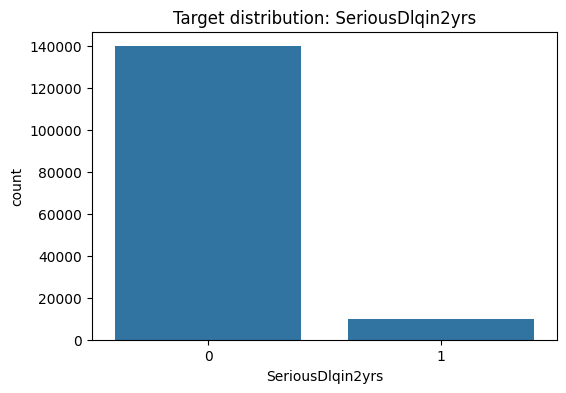

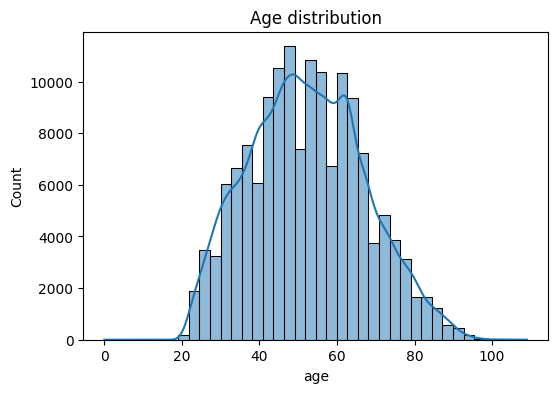

In [7]:
plt.figure(figsize=(6, 4))
sns.countplot(x="SeriousDlqin2yrs", data=df_train)
plt.title("Target distribution: SeriousDlqin2yrs")
plt.show()

plt.figure(figsize=(6, 4))
sns.histplot(df_train["age"], bins=40, kde=True)
plt.title("Age distribution")
plt.show()


target variable is disbalanced, its better to apply a few methods to fix it later

age distribution is near normal

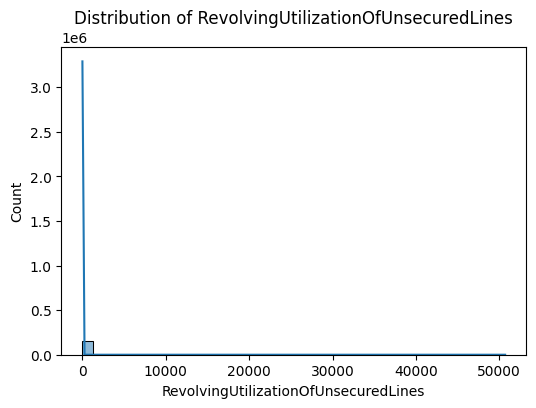

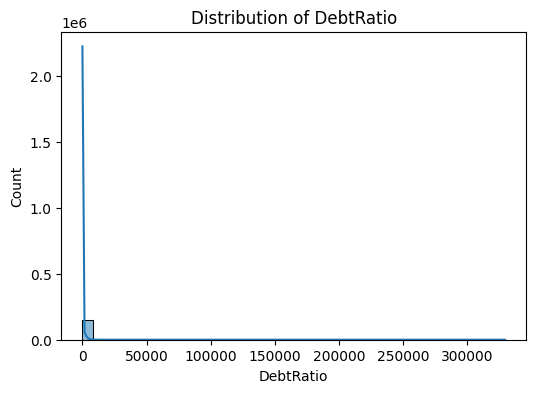

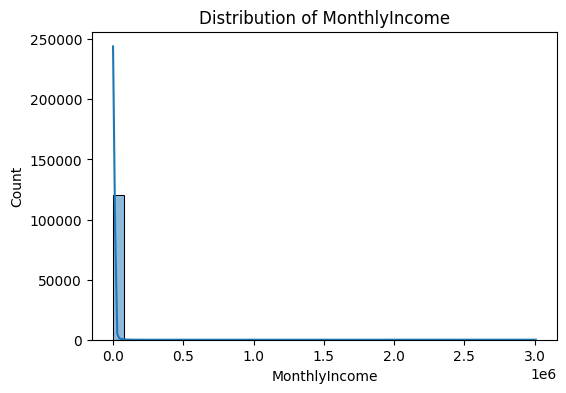

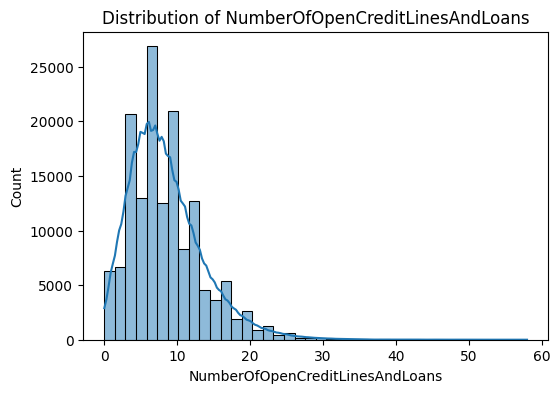

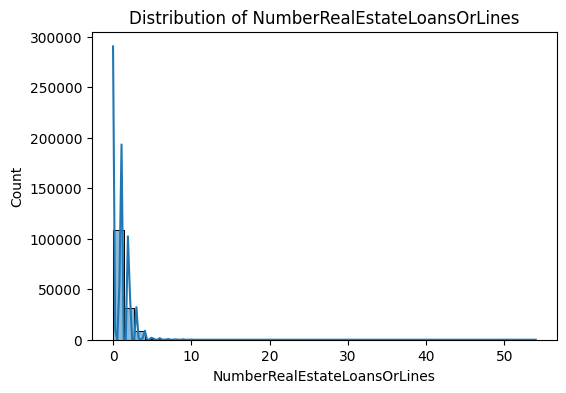

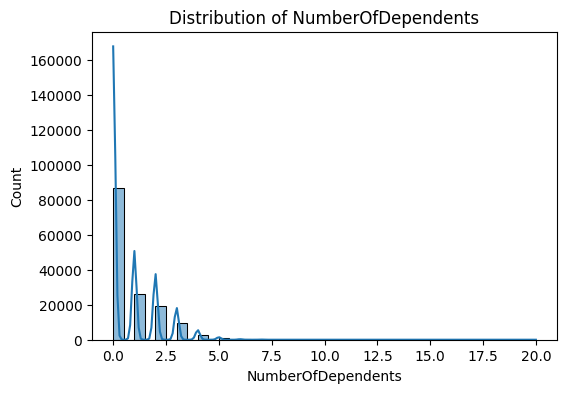

In [8]:
numeric_cols = [
    "RevolvingUtilizationOfUnsecuredLines",
    "DebtRatio",
    "MonthlyIncome",
    "NumberOfOpenCreditLinesAndLoans",
    "NumberRealEstateLoansOrLines",
    "NumberOfDependents"
]

for col in numeric_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(df_train[col].dropna(), bins=40, kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()


Some NumberOfDependendents are null. Most of num of dependents are zero, so lets replace Nan values with 0

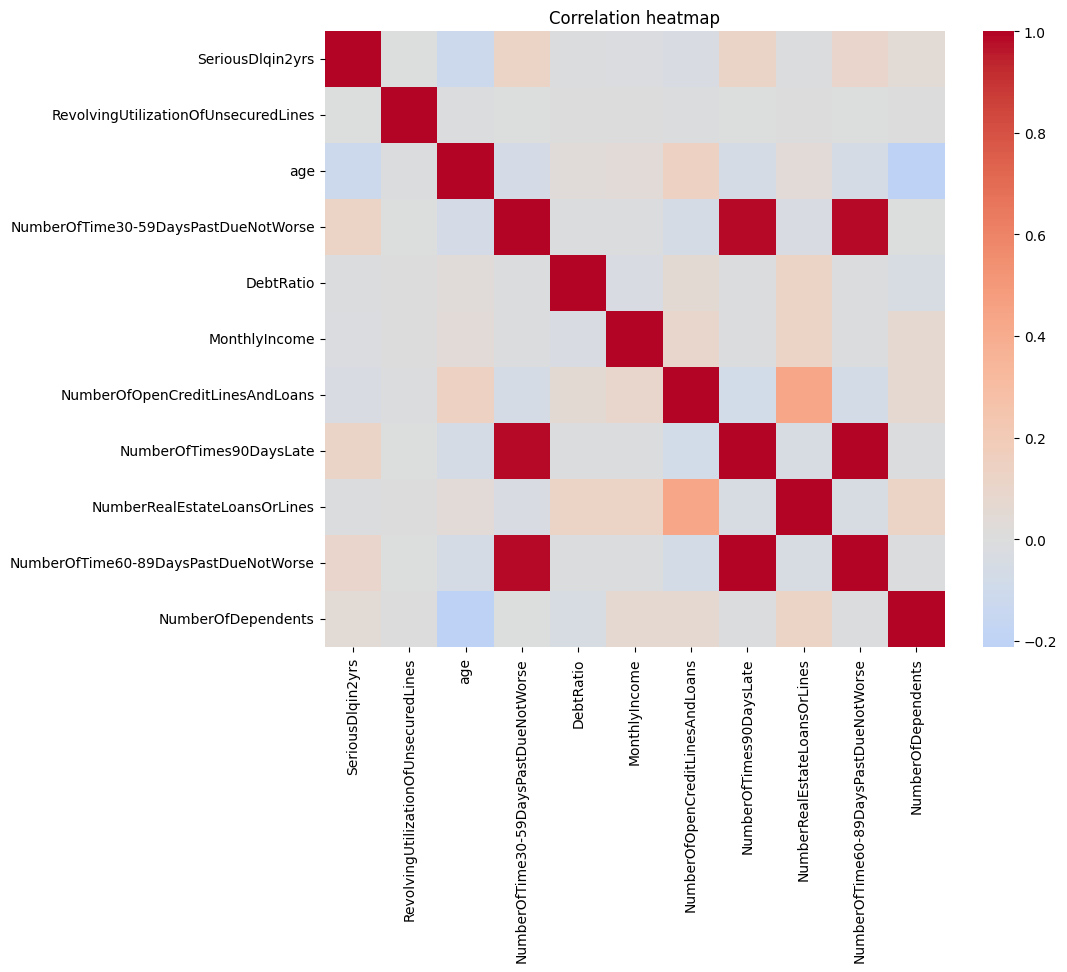

In [9]:
plt.figure(figsize=(10, 8))
corr = df_train.corr(numeric_only=True)
sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
plt.title("Correlation heatmap")
plt.show()


Some variables from dayspastduenotworse are high correlated because they are dependant.

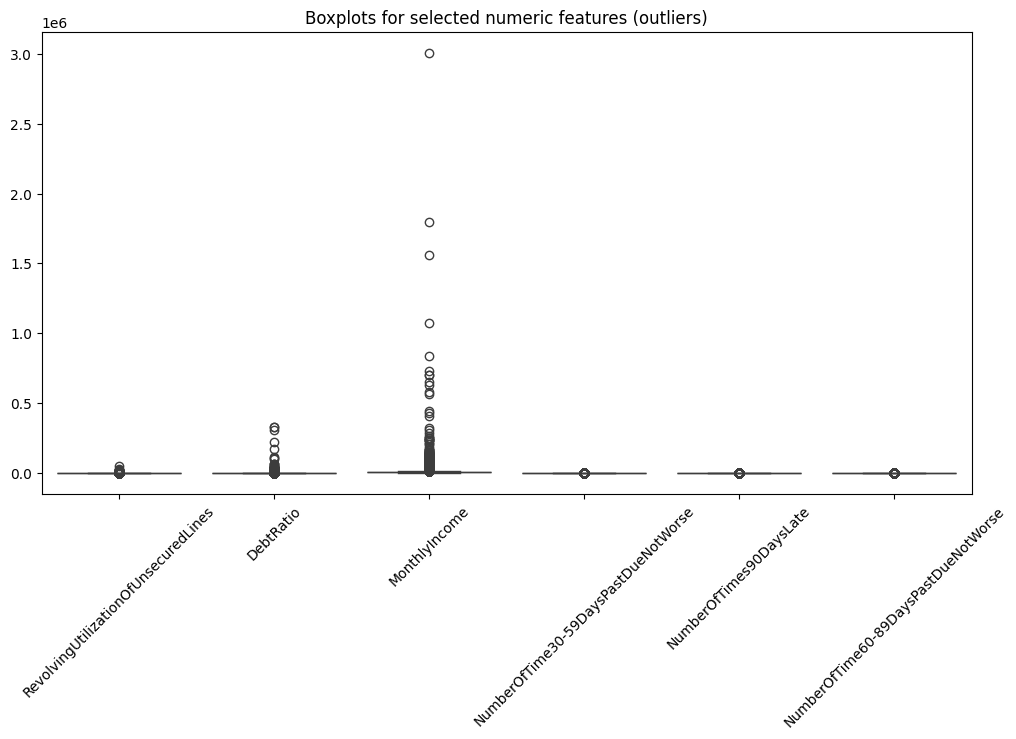

In [10]:
plt.figure(figsize=(12, 6))
subset_cols = [
    "RevolvingUtilizationOfUnsecuredLines",
    "DebtRatio",
    "MonthlyIncome",
    "NumberOfTime30-59DaysPastDueNotWorse",
    "NumberOfTimes90DaysLate",
    "NumberOfTime60-89DaysPastDueNotWorse"
]
sns.boxplot(data=df_train[subset_cols])
plt.xticks(rotation=45)
plt.title("Boxplots for selected numeric features (outliers)")
plt.show()


Monthly income and DepbtRatio has a lot of outliers high variance, so its better to apply log scale on them

In [11]:
df_train["MonthlyIncome"].fillna(df_train["MonthlyIncome"].median(), inplace=True)
df_train["NumberOfDependents"].fillna(0, inplace=True)

/tmp/ipython-input-2398882937.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train["MonthlyIncome"].fillna(df_train["MonthlyIncome"].median(), inplace=True)
/tmp/ipython-input-2398882937.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].me

# 2.Creating additional variables - (Task weight: 10%)

Be creative: the more variables, the higher the score! However, variables must be logical; illogical variables will not be accepted.

- 0 points if the task is not completed.
- 0.5 points - 2 additional variables created.
- 1 point - more than 3 variables created.


In [12]:
#combines all daypastdue counts into one risk measure
df_train["TotalPastDue"] = (
    df_train["NumberOfTime30-59DaysPastDueNotWorse"]
    + df_train["NumberOfTime60-89DaysPastDueNotWorse"]
    + df_train["NumberOfTimes90DaysLate"]
)

#flags if borrower was ever late
df_train["HasPastDue"] = (df_train["TotalPastDue"] > 0).astype(int)

#shows credit load relative to real-estate loans
df_train["CreditLinesPerRealEstate"] = (
    df_train["NumberOfOpenCreditLinesAndLoans"] /
    (df_train["NumberRealEstateLoansOrLines"] + 1)
)

#income adjusted for household size
df_train["IncomePerPerson"] = (
    df_train["MonthlyIncome"] /
    (df_train["NumberOfDependents"] + 1)
)


In [13]:
#As I wrote before - log scale for some vars

log_cols = [
    "RevolvingUtilizationOfUnsecuredLines",
    "DebtRatio",
    "MonthlyIncome",
    "TotalPastDue",
    "IncomePerPerson"
]

for col in log_cols:
    df_train[f"log_{col}"] = np.log1p(df_train[col].clip(lower=0))


In [14]:
df_train

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,TotalPastDue,HasPastDue,CreditLinesPerRealEstate,IncomePerPerson,log_RevolvingUtilizationOfUnsecuredLines,log_DebtRatio,log_MonthlyIncome,log_TotalPastDue,log_IncomePerPerson
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0,2,1,1.857143,3040.000000,0.568789,0.589442,9.118335,1.098612,8.019942
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0,0,0,4.000000,1300.000000,0.671490,0.115002,7.863651,0.000000,7.170888
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0,2,1,2.000000,3042.000000,0.505721,0.081684,8.020599,1.098612,8.020599
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0,0,0,5.000000,3300.000000,0.210107,0.035415,8.101981,0.000000,8.101981
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0,1,1,3.500000,63588.000000,0.645657,0.024620,11.060196,0.693147,11.060196
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149995,0,0.040674,74,0,0.225131,2100.0,4,0,1,0,0.0,0,0,2.000000,2100.000000,0.039868,0.203048,7.650169,0.000000,7.650169
149996,0,0.299745,44,0,0.716562,5584.0,4,0,1,0,2.0,0,0,2.000000,1861.333333,0.262168,0.540324,8.627840,0.000000,7.529585
149997,0,0.246044,58,0,3870.000000,5400.0,18,0,1,0,0.0,0,0,9.000000,5400.000000,0.219974,8.261268,8.594339,0.000000,8.594339
149998,0,0.000000,30,0,0.000000,5716.0,4,0,0,0,0.0,0,0,4.000000,5716.000000,0.000000,0.000000,8.651199,0.000000,8.651199


# 3. Model building - (Task weight: 50%)
A logistic regression must be built on the WoE variables.

- If any other model is built, the score is 0.

In [15]:
# Remember to split the data into test and train
from sklearn.model_selection import train_test_split
train, test, y_train, y_test = train_test_split(df_train.drop("SeriousDlqin2yrs", axis=1), df_train["SeriousDlqin2yrs"], test_size=0.2, random_state=42, shuffle=True, stratify=df_train["SeriousDlqin2yrs"])



Ive added stratify key to save distibutions of labels in train and val split

A WoE transformation must be calculated - maximum 3 points.

The WoE calculation must be done in two steps:

Step 1. Fine Classification (1 point). Splitting into a large number of bins (intervals).
- Typically, interval variables are divided into 20, 30, and so on intervals.
- For categorical variables, one category per group.
- Next, calculate the WoE for each group.

Step 2. Coarse Classification (2 points). Consolidating the intervals obtained in Step 1. The result should be no more than 5-10 intervals.
- Typically, groups with similar WoE values ​​are combined.
- The WoE must be monotonic, meaning that after your combination, the result must be interpretable (it is necessary to graphically demonstrate that the WoE is monotonic).


In [16]:
train_woe = train.copy()
train_woe["target"] = y_train.values

#Ive chosen updated variables that are most fitting for woe
features = [
    "log_RevolvingUtilizationOfUnsecuredLines",
    "age",
    #"log_DebtRatio",
    #"log1p_MonthlyIncome",
    #"NumberOfOpenCreditLinesAndLoans",
    "log_TotalPastDue",
    "log_IncomePerPerson",
]

woe_tables = {}

In [17]:
#Functions for woe

#Woe fine classification
def make_fine_woe(df, feature, target_col="target", n_bins=20):
    tmp = df[[feature, target_col]].dropna().copy()
    tmp["bin"] = pd.qcut(tmp[feature], q=n_bins, duplicates="drop")

    grouped = tmp.groupby("bin")[target_col].agg(["count", "sum"])
    grouped.rename(columns={"sum": "bad"}, inplace=True)
    grouped["good"] = grouped["count"] - grouped["bad"]

    total_good = grouped["good"].sum()
    total_bad = grouped["bad"].sum()

    grouped["dist_good"] = grouped["good"] / (total_good + 1e-6)
    grouped["dist_bad"] = grouped["bad"] / (total_bad + 1e-6)
    grouped["woe"] = np.log((grouped["dist_good"] + 1e-6) /
                            (grouped["dist_bad"] + 1e-6))

    grouped = grouped.reset_index()
    grouped["min"] = grouped["bin"].apply(lambda x: float(x.left))
    grouped["max"] = grouped["bin"].apply(lambda x: float(x.right))

    return grouped[["min", "max", "count", "good", "bad", "woe"]]



#Coarse classification
def make_coarse_woe(fine, max_bins=10, min_bins=5):
    tbl = fine.copy().reset_index(drop=True)

    while True:
        w = tbl["woe"].values
        n = len(tbl)

        if n <= min_bins:
            break

        diffs = np.abs(np.diff(w))
        idx = np.argmin(diffs)

        tbl.loc[idx, "max"] = tbl.loc[idx + 1, "max"]
        tbl.loc[idx, "count"] += tbl.loc[idx + 1, "count"]
        tbl.loc[idx, "good"] += tbl.loc[idx + 1, "good"]
        tbl.loc[idx, "bad"] += tbl.loc[idx + 1, "bad"]

        total_good = tbl["good"].sum()
        total_bad = tbl["bad"].sum()

        tbl.loc[idx, "dist_good"] = tbl.loc[idx, "good"] / (total_good + 1e-6)
        tbl.loc[idx, "dist_bad"] = tbl.loc[idx, "bad"] / (total_bad + 1e-6)
        tbl.loc[idx, "woe"] = np.log((tbl.loc[idx, "dist_good"] + 1e-6) /
                                     (tbl.loc[idx, "dist_bad"] + 1e-6))

        tbl = tbl.drop(index=idx + 1).reset_index(drop=True)

    tbl["min"] = tbl["min"].astype(float)
    tbl["max"] = tbl["max"].astype(float)

    return tbl[["min", "max", "woe"]]

/tmp/ipython-input-3728917535.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = tmp.groupby("bin")[target_col].agg(["count", "sum"])


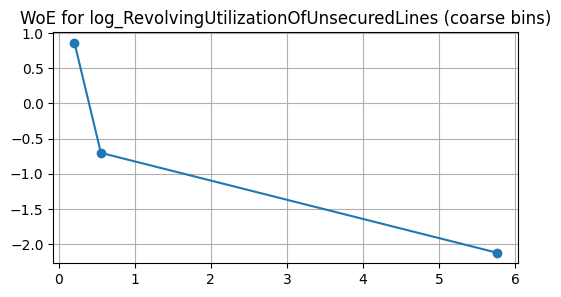

/tmp/ipython-input-3728917535.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = tmp.groupby("bin")[target_col].agg(["count", "sum"])


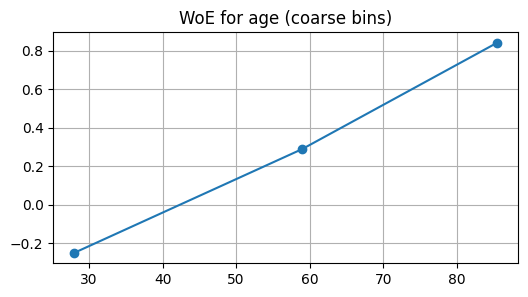

/tmp/ipython-input-3728917535.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = tmp.groupby("bin")[target_col].agg(["count", "sum"])


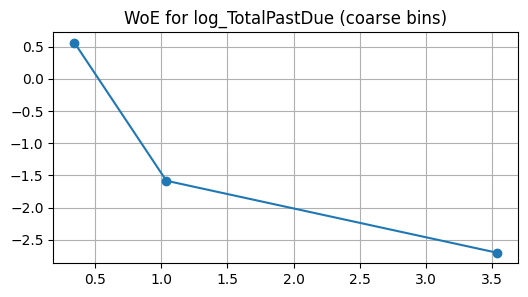

/tmp/ipython-input-3728917535.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = tmp.groupby("bin")[target_col].agg(["count", "sum"])


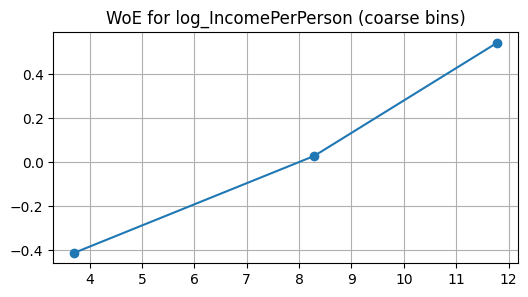

In [18]:
train_woe_final = pd.DataFrame(index=train.index)
test_woe_final = pd.DataFrame(index=test.index)

woe_tables = {}

for f in features:
    fine = make_fine_woe(train_woe, f, n_bins=30)
    coarse = make_coarse_woe(fine, max_bins=10, min_bins=3)
    woe_tables[f] = coarse

    #train
    col_train = pd.Series(np.nan, index=train.index)

    for i in range(len(coarse)):
        mn = coarse.iloc[i]["min"]
        mx = coarse.iloc[i]["max"]
        w  = coarse.iloc[i]["woe"]

        if i < len(coarse) - 1:
            mask = (train[f] >= mn) & (train[f] < mx)
        else:
            mask = (train[f] >= mn) & (train[f] <= mx)

        col_train[mask] = w

    train_woe_final[f] = col_train.fillna(0.0)

    #test
    col_test = pd.Series(np.nan, index=test.index)

    for i in range(len(coarse)):
        mn = coarse.iloc[i]["min"]
        mx = coarse.iloc[i]["max"]
        w  = coarse.iloc[i]["woe"]

        if i < len(coarse) - 1:
            mask = (test[f] >= mn) & (test[f] < mx)
        else:
            mask = (test[f] >= mn) & (test[f] <= mx)

        col_test[mask] = w

    test_woe_final[f] = col_test.fillna(0.0)


    centers = (coarse["min"] + coarse["max"]) / 2

    plt.figure(figsize=(6, 3))
    plt.plot(centers, coarse["woe"], marker="o")
    plt.title(f"WoE for {f} (coarse bins)")
    plt.grid(True)
    plt.show()


All values are monotonic or has an arrow. Like monthly income. For low income risk is high, for medium - low, for high income risk to high too

Before I tried to add log monthly income and  num of open credit lines and loans, but they were not monotonic. I removed them and scores increased on the next model

Constructing and evaluating logistic regression - maximum 1 point
- Constructing only logistic regression - 0.3 points
- Evaluating the model (roc auc, f1, etc.) - 0.3 points
- Constructing a scorecard - 0.4 points

As a reminder, the following formulas are required for the scorecard (details in the lecture and seminar):
Score_i =  (βi × WoE_i + α/n) × Factor + Offset/n, где

- Factor = pdo/ln(2)

- Offset = Target Score — (Factor × ln(Target Odds))

Constructing only logistic regression

In [19]:
X_train = train_woe_final
X_test  = test_woe_final
y_train = y_train
y_test  = y_test

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

Evaluating the model

In [20]:
y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba > 0.5).astype(int)

roc_auc = roc_auc_score(y_test, y_pred_proba)
f1 = f1_score(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)

print("roc-auc:", roc_auc)
print("F1:", f1)
print("Accuracy:", acc)
print(classification_report(y_test, y_pred))


roc-auc: 0.8460168920438679
F1: 0.21567043618739903
Accuracy: 0.9352666666666667
              precision    recall  f1-score   support

           0       0.94      0.99      0.97     27995
           1       0.57      0.13      0.22      2005

    accuracy                           0.94     30000
   macro avg       0.75      0.56      0.59     30000
weighted avg       0.92      0.94      0.92     30000



High accuracy and low f1 means that classes are too disbalanced and model just choose 0 often (so high recall on 0 and low on 1)

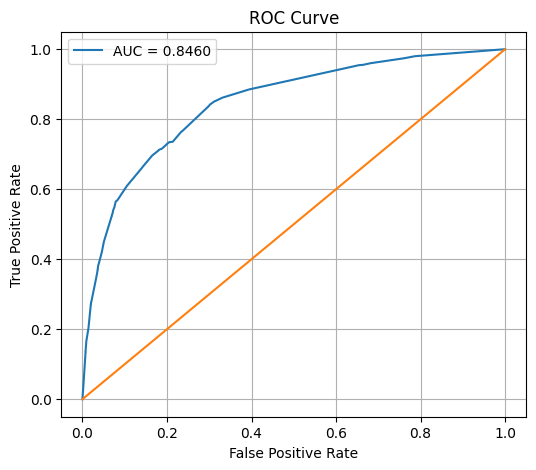

In [21]:
fpr, tpr, thr = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], "-")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()


Roc auc is 0.846, that means model has actually ability to predict classes but not just random

Constructing a scorecard

In [22]:
pdo = 20
ts = 600
to = 50

factor = pdo/np.log(2)
offset = ts - factor * np.log(to)

b = model.coef_[0]
a = model.intercept_[0]
n = len(b)

scorecard = pd.DataFrame({
    "feature": X_train.columns,
    "beta": b
})

scorecard

,feature,beta
0,log_RevolvingUtilizationOfUnsecuredLines,-0.520316
1,age,-0.510830
2,log_TotalPastDue,-0.794123
3,log_IncomePerPerson,-0.373263


All betas are logically correct

In [23]:
score_bins = []

for f in features:
    table = woe_tables[f].copy()
    b = scorecard.loc[scorecard["feature"] == f, "beta"].iloc[0]

    table["feature"] = f
    table["Score"] = (b * table["woe"] + a / n) * factor + offset / n

    score_bins.append(table)
scorecard_table = pd.concat(score_bins, ignore_index=True)
scorecard_table

,min,max,woe,feature,Score
0,-0.001,0.418,0.863212,log_RevolvingUtilizationOfUnsecuredLines,86.978684
1,0.418,0.693,-0.702265,log_RevolvingUtilizationOfUnsecuredLines,110.481421
2,0.693,10.834,-2.122949,log_RevolvingUtilizationOfUnsecuredLines,131.810364
3,-0.001,56.000,-0.251112,age,103.639454
4,56.000,62.000,0.288726,age,95.682539
5,62.000,109.000,0.841586,age,87.533689
6,-0.001,0.693,0.561198,log_TotalPastDue,87.079168
7,0.693,1.386,-1.583470,log_TotalPastDue,136.221126
8,1.386,5.687,-2.703285,log_TotalPastDue,161.880055
9,-0.001,7.419,-0.410503,log_IncomePerPerson,104.359369


change in woe -> change in score monotinic. everything is correct

Conduct a sample stability analysis using PSI
- Compare the test and training samples you downloaded from Kaggle (df_train, df_test)

In [24]:
def psi_for_feature(expected, actual, bins=10, eps=1e-6):
    quantiles = np.linspace(0, 1, bins + 1)
    cuts = np.quantile(expected, quantiles)

    expected_binned = pd.cut(expected, bins=cuts, include_lowest=True, duplicates="drop")
    actual_binned   = pd.cut(actual,   bins=cuts, include_lowest=True, duplicates="drop")

    expected_dist = expected_binned.value_counts(normalize=True).sort_index()
    actual_dist   = actual_binned.value_counts(normalize=True).sort_index()

    psi = ((actual_dist - expected_dist) * np.log((actual_dist + eps) / (expected_dist + eps))).sum()
    return psi


def psi_dataframe(df_train, df_test, features, bins=10):
    psi_values = {}
    for f in features:
        psi_values[f] = psi_for_feature(df_train[f].dropna(), df_test[f].dropna(), bins=bins)
    return pd.DataFrame.from_dict(psi_values, orient="index", columns=["PSI"])


df_train, df_test = load_dataset(from_kaggle=True)
df_train.drop("Unnamed: 0", axis=1, inplace=True)
num_cols = df_train.select_dtypes(include=[np.number]).columns.tolist()
psi_table = psi_dataframe(df_train, df_test, num_cols, bins=10)
psi_table.sort_values("PSI", ascending=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
mkdir: cannot create directory ‘/root/.kaggle’: File exists
GiveMeSomeCredit.zip: Skipping, found more recently modified local copy (use --force to force download)


,PSI
MonthlyIncome,0.000398
NumberOfDependents,0.000136
DebtRatio,0.000120
RevolvingUtilizationOfUnsecuredLines,0.000120
age,0.000117
NumberOfOpenCreditLinesAndLoans,0.000113
NumberRealEstateLoansOrLines,0.000086
NumberOfTime30-59DaysPastDueNotWorse,0.000018
SeriousDlqin2yrs,0.000000
NumberOfTimes90DaysLate,0.000000


all psi are small and < 0.1 so samples are stable and distribution of train and test are ok

# 4. Using methods to reduce class imbalance - (Task weight: 20%)
- Try several methods to reduce class imbalance
- Choose the one that brings the greatest improvement

In [25]:
def evaluate_model(model, X_test, y_test):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_pred_proba > 0.5).astype(int)

    roc_auc = roc_auc_score(y_test, y_pred_proba)
    f1 = f1_score(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)

    print("ROC-AUC:", roc_auc)
    print("F1:", f1)
    print("Accuracy:", acc)
    print(classification_report(y_test, y_pred))


In [26]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

print("baseline")
evaluate_model(model, X_test, y_test)


baseline
ROC-AUC: 0.8460168920438679
F1: 0.21567043618739903
Accuracy: 0.9352666666666667
              precision    recall  f1-score   support

           0       0.94      0.99      0.97     27995
           1       0.57      0.13      0.22      2005

    accuracy                           0.94     30000
   macro avg       0.75      0.56      0.59     30000
weighted avg       0.92      0.94      0.92     30000



In [27]:
model_balanced = LogisticRegression(max_iter=1000, class_weight='balanced')
model_balanced.fit(X_train, y_train)

print("class_weight=balanced")
evaluate_model(model_balanced, X_test, y_test)


class_weight=balanced
ROC-AUC: 0.8457116540671896
F1: 0.3320956138315154
Accuracy: 0.8081333333333334
              precision    recall  f1-score   support

           0       0.98      0.81      0.89     27995
           1       0.22      0.71      0.33      2005

    accuracy                           0.81     30000
   macro avg       0.60      0.76      0.61     30000
weighted avg       0.92      0.81      0.85     30000



In [28]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler()
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

model_rus = LogisticRegression(max_iter=1000)
model_rus.fit(X_train_rus, y_train_rus)

print("random undersampling")
evaluate_model(model_rus, X_test, y_test)


random undersampling
ROC-AUC: 0.8459414956090752
F1: 0.3320956138315154
Accuracy: 0.8081333333333334
              precision    recall  f1-score   support

           0       0.98      0.81      0.89     27995
           1       0.22      0.71      0.33      2005

    accuracy                           0.81     30000
   macro avg       0.60      0.76      0.61     30000
weighted avg       0.92      0.81      0.85     30000



In [29]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

model_ros = LogisticRegression(max_iter=1000)
model_ros.fit(X_train_ros, y_train_ros)

print("random oversampling")
evaluate_model(model_ros, X_test, y_test)


random oversampling
ROC-AUC: 0.8456827390356044
F1: 0.3320956138315154
Accuracy: 0.8081333333333334
              precision    recall  f1-score   support

           0       0.98      0.81      0.89     27995
           1       0.22      0.71      0.33      2005

    accuracy                           0.81     30000
   macro avg       0.60      0.76      0.61     30000
weighted avg       0.92      0.81      0.85     30000



Ive tried 3 methods to retuce impact of disbalance. base model showed high accurace but actually it just always predict 0 and useless for real business

The highest result has undersampling but in real life deleting data can cause less stability. Results of class_weight=balanced where logistic regression gives weights to train data according to distribution are ~ equals the undersampling but more stable.

recall increased from 0.13 to 0.71 so model predicts correctly bad cliend in 71% of cases, roc auc at the same time stayed the same